In [2]:
from scipy.integrate import solve_ivp
from scipy.stats import gamma as gamma_dist
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [3]:
import sys
sys.path.append("../code")
import model
import plotting
import parametros

In [4]:
for i in range(3):
    print(f'Scenario {i+1}:', parametros.Rtbase[f'scenario{i+1}'])

Scenario 1: 5
Scenario 2: 3.75
Scenario 3: 2.5


In [5]:
params_m1 = parametros.params.copy()
params_m2 = parametros.params.copy()
params_m3 = parametros.params.copy()

params_m1["Rt_base"] = parametros.Rtbase['scenario3']
params_m2["Rt_base"] = parametros.Rtbase['scenario2']
params_m3["Rt_base"] = parametros.Rtbase['scenario1']

m1 = model.Model(**params_m1)
m2 = model.Model(**params_m2)
m3 = model.Model(**params_m3)

In [6]:
print('Initials',params_m1["y0"])
print('Delta',params_m1["delta"])
print('Theta',params_m1["Theta"])
print('ThetaICU',params_m1["Theta_ICU"])

Initials [276618.0, 599864.0, 97500.0, 390.0, 39.0, 974.0, 97.0, 18.0, 24500.0, 604864, 5000, 0.0, 0.0]
Delta 0.0019
Theta 0.0005366
ThetaICU 0.09755


In [7]:
times, data = m1.run()
times, data = m2.run()
times, data = m3.run()

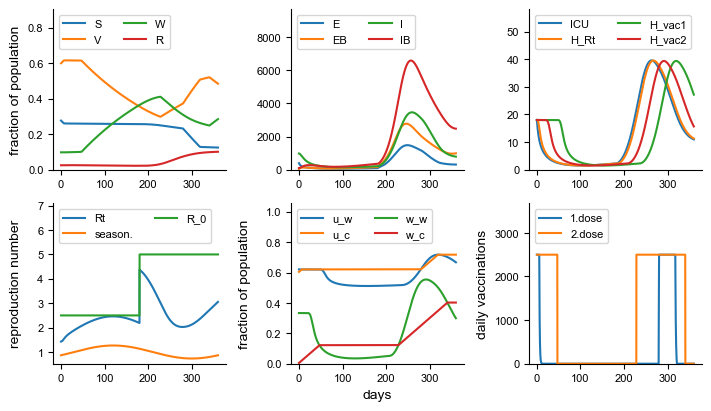

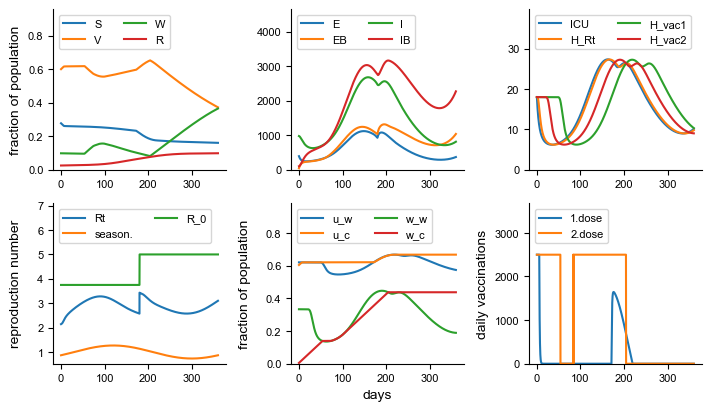

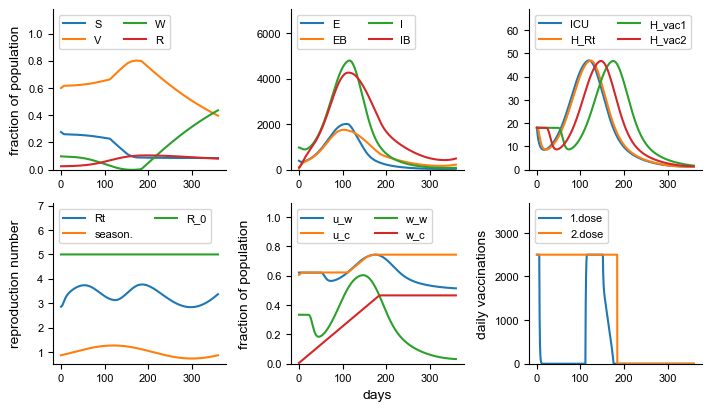

In [8]:
plotting.overview(m1)
plotting.overview(m2)
plotting.overview(m3)

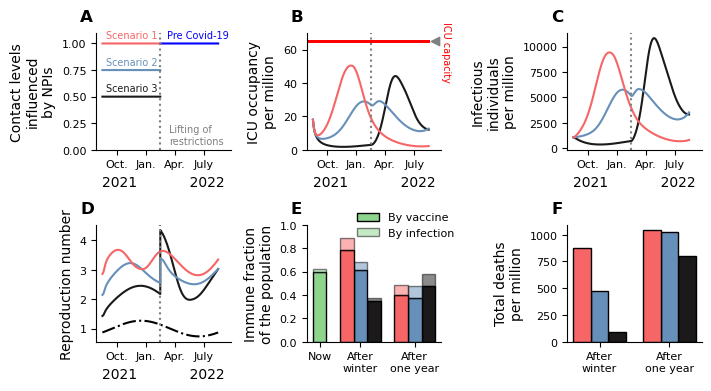

In [47]:
# reset defaults
mpl.rcParams.update(mpl.rcParamsDefault)

#mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

#mpl.rcParams['axes.linewidth'] = 0.3
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 10
mpl.rcParams["axes.titlesize"]= 10
mpl.rcParams["legend.fontsize"] = 8
mpl.rcParams["legend.title_fontsize"] = 10

fig = plt.figure(figsize=(7*3/3, 2*1.9), constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=2, wspace=0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1], sharex=ax1)
ax3 = fig.add_subplot(grid[4])
ax4 = fig.add_subplot(grid[5])
ax5 = fig.add_subplot(grid[2], sharex=ax1)
ax6 = fig.add_subplot(grid[3], sharex=ax1)

c = {
    'low':'#1b191a', 'mid':'#6690ba', 'high':'#f66666', 'free':'blue',
    'line':'gray', 'ICUcap':'#FFAAAA',
}
c3 = {'vacc':'#be93da', 'recov':'#e9f4d2'}
c4 = {'start':'#d7d7d7', 'spring':'#999999', 'fall':'#515151'}
tmp = [c['low'],c['mid'],c['high']]


offset = 0.5


ax1.plot(m1.times[1800:], np.ones(1800), color=c['free'])
for i in range(3):
    ax1.plot(m1.times[:1800], parametros.Rtbase[f'scenario{i+1}']/parametros.params['Rt_free']*np.ones(len(m1.times[:1800])),
            color=tmp[2-i])
    
    
for i,m in enumerate([m1,m2,m3]):
    ax2.plot(m.times, m.chopped_data()[:,7], color=tmp[i])
    ax5.plot(m.times, (m.chopped_data()[:,5]+m.chopped_data()[:,6]), color=tmp[i])
    ax6.plot(m.times, list(map(m.Rt, m.times)), color=tmp[i], label='Rt')
    
ax6.plot(m.times, list(map(m1.Gamma, m.times)), color='black', linestyle='-.', label='Seasonality')
    
 
ax3.bar(1, m3.chopped_data()[0,1]/1e6, 0.5,  alpha=1, label='By vaccine',
            align='center', color='#8ed48c', edgecolor='Black' , zorder=-1)
ax3.bar(1, m3.chopped_data()[0,8]/1e6, 0.5,  alpha=0.5, label='By infection',
            align='center', color='#8ed48c', edgecolor='Black' , zorder=-1, bottom=m3.chopped_data()[0,1]/1e6)

for i in [2,4]:
    for ab, m in zip([0.5,0,-0.5],[m1,m2,m3]):
        ax3.bar(offset+i+ab, m.chopped_data()[900*i-1,1]/1e6, 0.5,  
                align='center', color=tmp[round(2-(ab+0.5)*2)], edgecolor='black' , zorder=-1)
        ax3.bar(offset+i+ab, m.chopped_data()[900*i-1,8]/1e6, 0.5, alpha=0.5,
                align='center', color=tmp[round(2-(ab+0.5)*2)], edgecolor='black' , zorder=-1, bottom=m.chopped_data()[900*i-1,1]/1e6)
        ax4.bar(offset+i+ab, m.chopped_data()[900*i-1,11], 0.5, 
                    align='center', color=tmp[round(2-(ab+0.5)*2)], edgecolor='black' , zorder=-3)
 




for ax in [ax1,ax2,ax5,ax6]:
    ax.axvline(180, ls=':', color=c['line'])
    ax.set_xlabel('2021            2022')


ax1.set_ylim(0,1.1)
ax2.set_ylim(0,70)
ax3.set_ylim(0,1)
ax4.set_ylim(0,None)

ax1.set_ylabel("Contact levels\ninfluenced\nby NPIs")
ax2.set_ylabel("ICU occupancy\nper million")
ax3.set_ylabel("Immune fraction\nof the population")
ax4.set_ylabel("Total deaths\nper million")
ax5.set_ylabel("Infectious\nindividuals\nper million")
ax6.set_ylabel("Reproduction number")

#Panel 1
ax1.text(10,parametros.Rtbase['scenario3']/5+0.05,'Scenario 3', size=7, color=c['low'])
ax1.text(10,parametros.Rtbase['scenario2']/5+0.05,'Scenario 2', size=7, color=c['mid'])
ax1.text(10,parametros.Rtbase['scenario1']/5+0.05,'Scenario 1', size=7, color=c['high'])
ax1.text(200,parametros.Rtbase['scenario1']/5+0.05,'Pre Covid-19', size=7, color=c['free'])

#Lifting of restrictions
ax1.text(0.54,0.05,'Lifting of\nrestrictions', size=7, color=c['line'], transform=ax1.transAxes)
#ax2.text(0.08,1,'Lifting of\nrestrictions', size=7, color=c['line'], transform=ax2.transAxes)
#ax5.text(0.08,0.9,'Lifting of\nrestrictions', size=7, color=c['line'], transform=ax5.transAxes)


ax1.text(-.12,1.1,'A', size=12, weight='bold', color='black', transform=ax1.transAxes)
ax2.text(-.12,1.1,'B', size=12, weight='bold', color='black', transform=ax2.transAxes)
ax5.text(-.12,1.1,'C', size=12, weight='bold', color='black', transform=ax5.transAxes)
ax6.text(-.12,1.1,'D', size=12, weight='bold', color='black', transform=ax6.transAxes)
ax3.text(-.12,1.1,'E', size=12, weight='bold', color='black', transform=ax3.transAxes)
ax4.text(-.12,1.1,'F', size=12, weight='bold', color='black', transform=ax4.transAxes)


ax2.axhspan(65-1,65+1, xmax=0.92, facecolor='red', edgecolor=None, zorder=-1)
ax2.text(1.0,0.6,'ICU capacity', size=7, color='red', rotation=-90, transform=ax2.transAxes)
ax2.scatter(380,65, marker="<", color='grey')


ax1.set_xticks([45, 135, 45+2*90, 45+3*90])
ax1.set_xticklabels(['Oct.','Jan.','Apr.','July'])


ax3_x = [1,offset+2,offset+4]
ax3labels=['Now','After\nwinter', 'After\none year']
ax3.set_xticks(ax3_x)
ax3.set_xticklabels(ax3labels)


ax4_x = [offset+2,offset+4]
ax4labels=['After\nwinter', 'After\none year']
ax4.set_xticks(ax4_x)
ax4.set_xticklabels(ax4labels)


ax3.legend(bbox_to_anchor=(0.3,0.8), ncol=1, frameon=False)

plt.show()
fig.savefig("./figures/paper_fig1_6panels.pdf")